# Compare OneK1K Objects +/- Cell Cycle Genes

In [1]:
# Run before executing any other cell

import pandas as pd
import numpy as np
import scanpy as sc
import pp, cna
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig_dir = "/data/srlab/lrumker/MCSC_Project/cna-qtl/figs/"
src_folder = "/data/srlab/lrumker/datasets/onek1k/pheno/"
np.random.seed(0)

In [2]:
# Export information of interest from data objects
n_nampcs = {"Myeloid": 24, "NK": 17, "B": 15, "T": 33, "allcells": 49} 

for celltype in ["allcells", "Myeloid", "NK", "T", "B"]:
    discovery = cna.read(src_folder+celltype+".h5ad")
    pd.DataFrame({"var_genes": discovery.var.index}).to_csv(src_folder+"CCGs_retained_GeNA_revisions/"+\
                                                            celltype+"_var_genes.csv", index=False, header=False)
    nampcs = discovery.uns['NAM_sampleXpc'].iloc[:,:n_nampcs[celltype]]
    nampcs.to_csv(src_folder+"CCGs_retained_GeNA_revisions/"+celltype+"_nampcs.csv")
    del discovery

    wCCG = cna.read(src_folder+"CCGs_retained_GeNA_revisions/"+celltype+"_wCCGs.h5ad")
    pd.DataFrame({"var_genes": wCCG.var.index}).to_csv(src_folder+"CCGs_retained_GeNA_revisions/"+\
                                                       celltype+"_wCCG_var_genes.csv", index=False, header=False)
    nampcs = wCCG.uns['NAM_sampleXpc'].iloc[:,:n_nampcs[celltype]]
    nampcs.to_csv(src_folder+"CCGs_retained_GeNA_revisions/"+celltype+"_wCCG_nampcs.csv")
    del wCCG

In [3]:
# Load information of interest from data objects
nampcs = {}
var_genes = {}

for celltype in ['Myeloid', 'NK', 'T', 'B', 'allcells']:
    new = pd.read_csv(src_folder+"CCGs_retained_GeNA_revisions/"+celltype+"_var_genes.csv",header=None).iloc[:,0].values
    var_genes[celltype] = new

    new = pd.read_csv(src_folder+"CCGs_retained_GeNA_revisions/"+celltype+"_wCCG_var_genes.csv",header=None).iloc[:,0].values
    var_genes[celltype+'_wCCG'] = new

    new = pd.read_csv(src_folder+"CCGs_retained_GeNA_revisions/"+celltype+"_nampcs.csv", index_col=0)
    nampcs[celltype] = new

    new = pd.read_csv(src_folder+"CCGs_retained_GeNA_revisions/"+celltype+"_wCCG_nampcs.csv", index_col=0)
    nampcs[celltype+'_wCCG'] = new

In [4]:
# Duplicate list of CCGs (excluded) from primary data processing pipeline
cc_genes = ["MCM5","PCNA","TYMS","FEN1","MCM2","MCM4", "RRM1","UNG","GINS2","MCM6",
            "CDCA7","DTL","PRIM1","UHRF1","MLF1IP","HELLS","RFC2","RPA2","NASP", 
            "RAD51AP1","GMNN","WDR76","SLBP","CCNE2","UBR7","POLD3","MSH2","ATAD2",
            "RAD51","RRM2", "CDC45", "CDC6", "EXO1", "TIPIN", "DSCC1", "BLM", "CASP8AP2",
            "USP1","CLSPN","POLA1","CHAF1B","BRIP1","E2F8","HMGB2","CDK1","NUSAP1","UBE2C",
            "BIRC5","TPX2","TOP2A","NDC80","CKS2","NUF2","CKS1B","MKI67","TMPO","CENPF",
            "TACC3","FAM64A","SMC4","CCNB2","CKAP2L","CKAP2","AURKB","BUB1","KIF11",
            "ANP32E","TUBB4B","GTSE1","KIF20B","HJURP","CDCA3","HN1", "CDC20", "TTK",
            "CDC25C", "KIF2C", "RANGAP1", "NCAPD2", "DLGAP5", "CDCA2", "CDCA8", "ECT2", 
            "KIF23", "HMMR", "AURKA", "PSRC1", "ANLN", "LBR", "CKAP5", "CENPE", "CTCF",
            "NEK2","G2E3","GAS2L3","CBX5","CENPA"]

In [5]:
# How many CCGs would have been selected as top variable genes?

celltypes=['Myeloid', 'NK', 'B', 'T', 'allcells']
n_variable_CCGs = []
for celltype in celltypes:
    n_variable_CCGs.append(np.sum([var_genes[celltype+"_wCCG"][i] in cc_genes \
                            for i in np.arange(var_genes[celltype+"_wCCG"].shape[0])]))
export = pd.DataFrame({"Cell type": celltypes, "CCGs": n_variable_CCGs})

with open('/data/srlab/lrumker/MCSC_Project/cna-qtl/tables/supptable.CCGs_retained.tex','w') as tf:
    tf.write(export.to_latex(index = False))
export

,Cell type,CCGs
0,Myeloid,6
1,NK,16
2,B,4
3,T,7
4,allcells,9


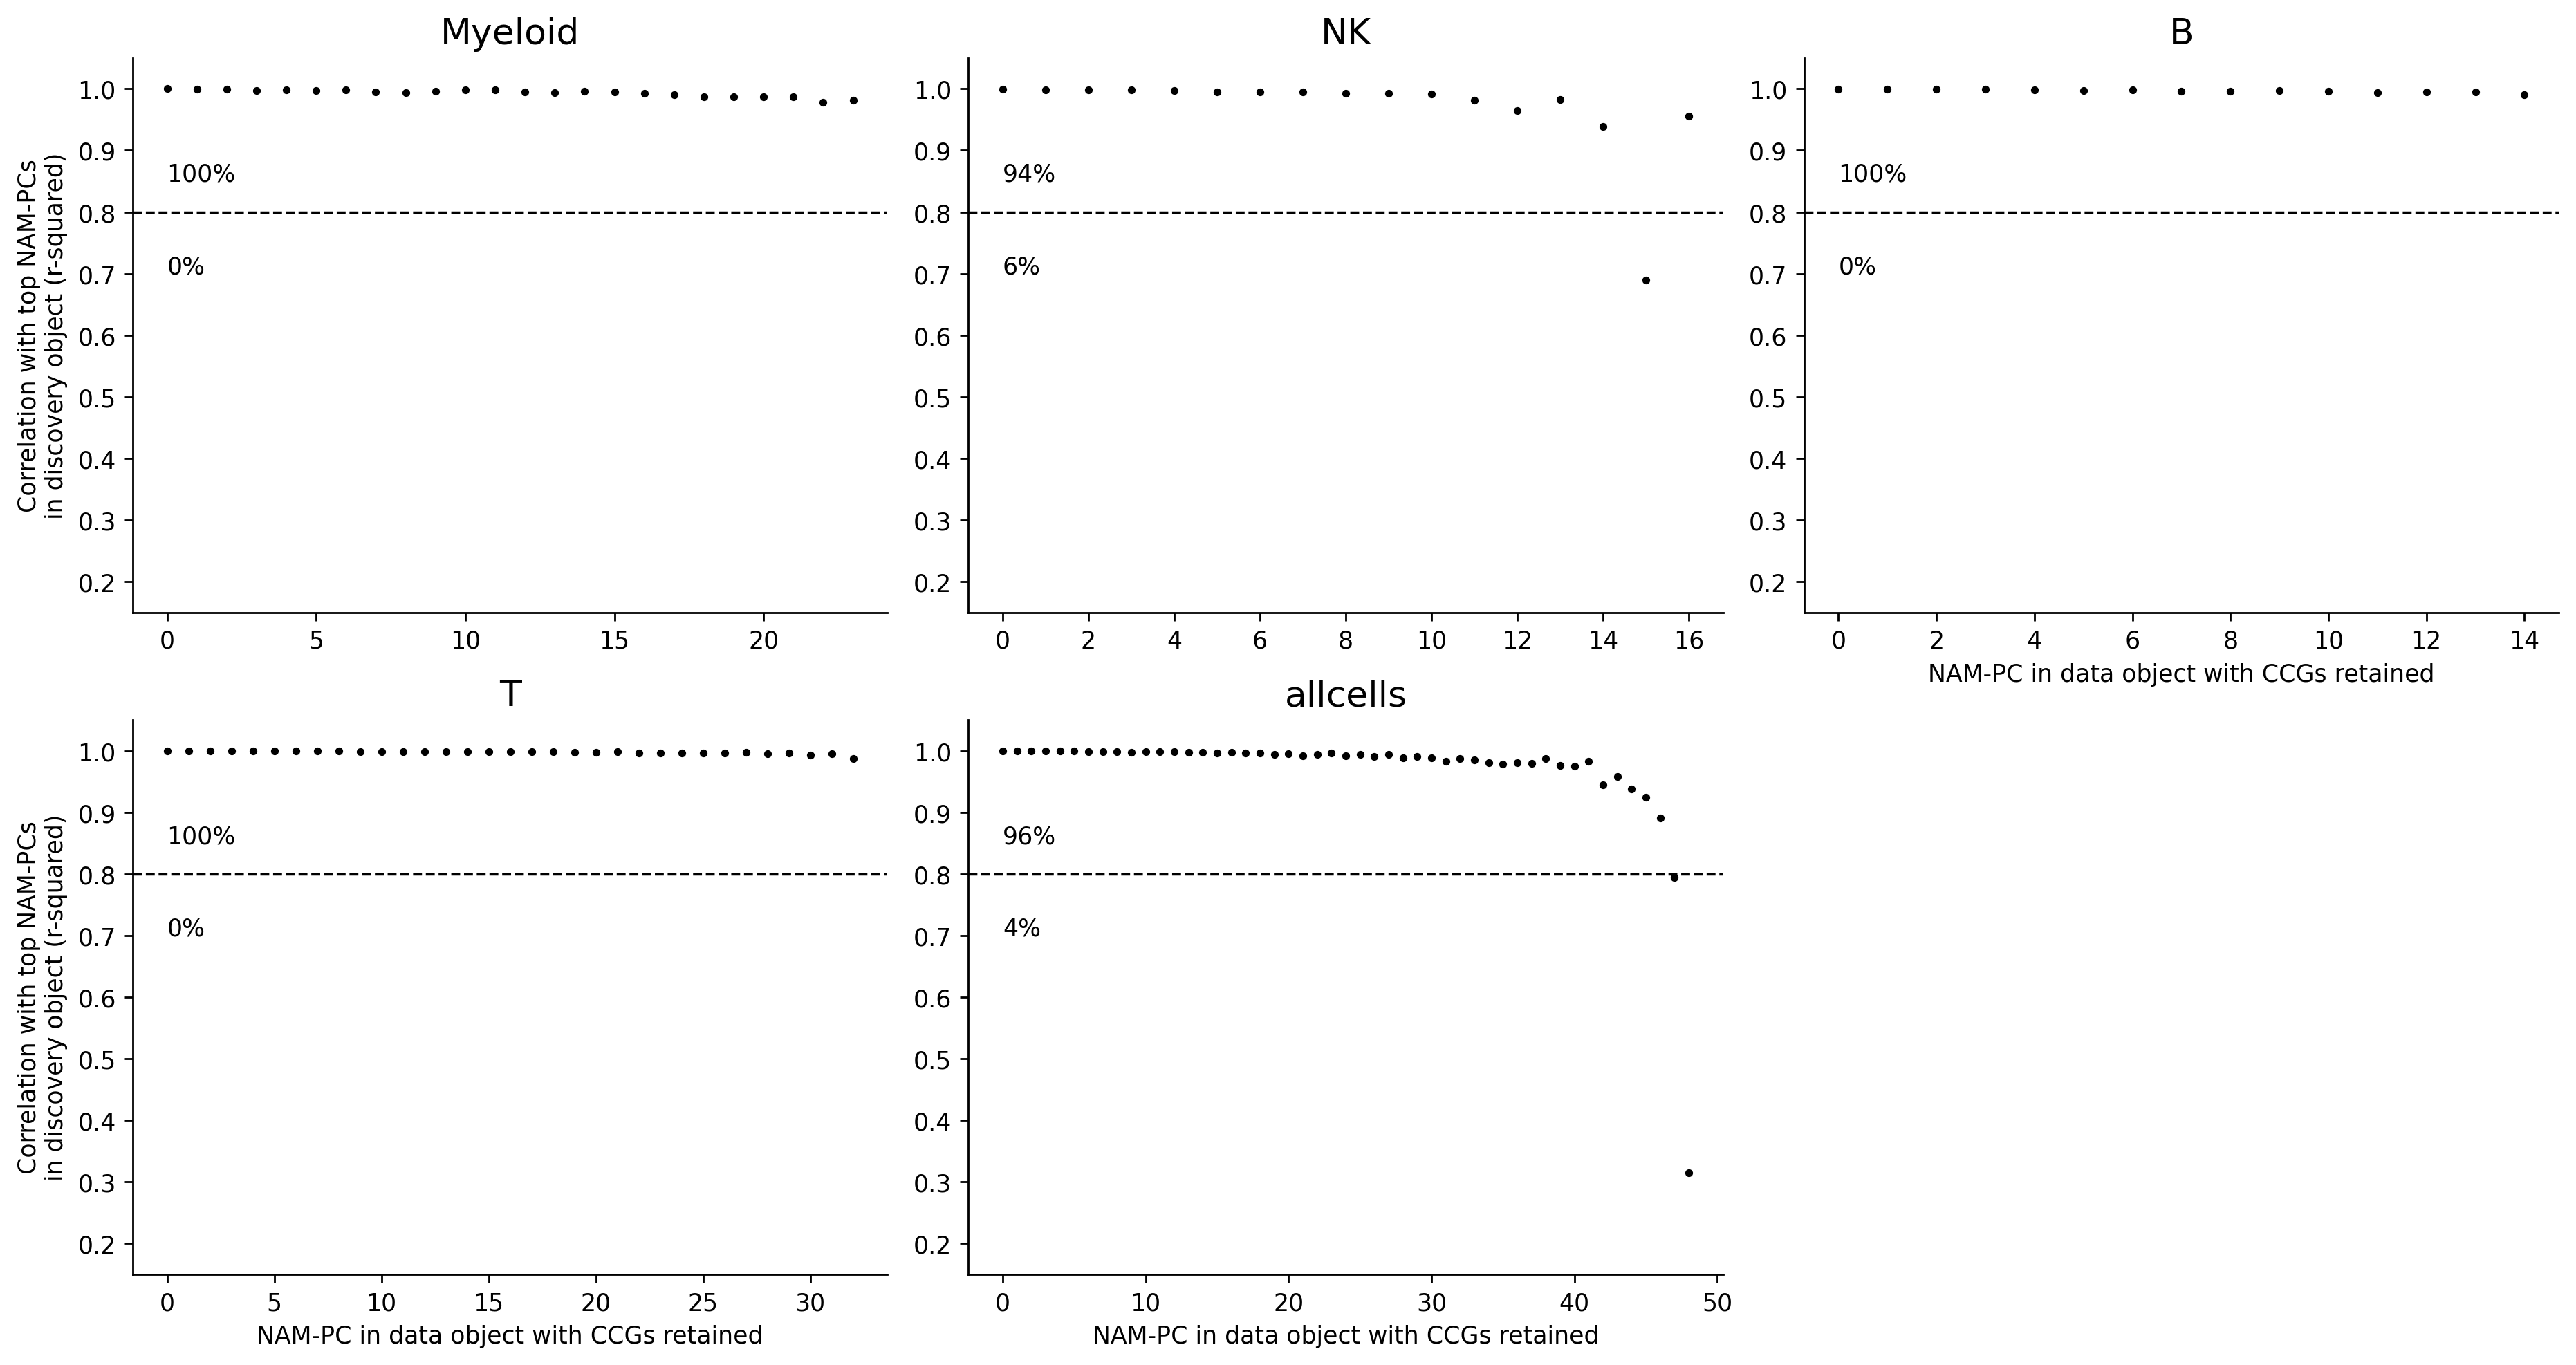

In [6]:
# Are new NAM-PCs revealed?

fig, axes = plt.subplots(2,3, dpi = 250, figsize = (15,8))
axes = axes.reshape(-1,)
for j in np.arange(len(celltypes)):
    ax = axes[j]
    celltype = celltypes[j]
    nampc_cors = []
    for i in np.arange(n_nampcs[celltype]):
        linmod = sm.OLS(nampcs[celltype+"_wCCG"].iloc[:,i].astype(float), 
                nampcs[celltype].iloc[:,:n_nampcs[celltype]]).fit() #fit linear regression model
        y_hat = np.dot(nampcs[celltype].iloc[:,:n_nampcs[celltype]], np.array(linmod.params).reshape(-1,1))
        rsq = np.corrcoef(nampcs[celltype+"_wCCG"].iloc[:,i].values, y_hat.reshape(-1,))[0,1]**2
        nampc_cors.append(rsq)
    ax.scatter(np.arange(n_nampcs[celltype]), nampc_cors, c = "black", s=5)
    ax.axhline(y=0.8, c = "black", ls="--", lw = 1)
    ax.set_ylim([0.15,1.05])
    
    ax.set_title(celltype, fontsize=15)
    if j in [2,3,4]:
        ax.set_xlabel("NAM-PC in data object with CCGs retained")
    if j in [0,3]:
        ax.set_ylabel("Correlation with top NAM-PCs\nin discovery object (r-squared)")
    ax.text(0, 0.85, str(int(np.around(np.sum(np.array(nampc_cors)>0.8)/len(nampc_cors),2)*100))+"%")
    ax.text(0, 0.7, str(100-int(np.around(np.sum(np.array(nampc_cors)>0.8)/len(nampc_cors),2)*100))+"%")
    
    # remove top / right spines
    ax.spines[['right', 'top']].set_visible(False)

axes[5].axis("off")
plt.tight_layout()
plt.savefig(fig_dir+"suppfig.CCG_retain_NAMPCs.png", bbox_inches='tight')
plt.show()

## csaQTL GWAS lead SNPs

Load results of GeNA GWASs from wCCG data objects

In [7]:
all_res = pd.DataFrame({})
for celltype in ['NK', 'B', 'T', 'allcells', 'Myeloid']:
    new = pd.read_csv("/data/srlab/lrumker/MCSC_Project/cna-qtl/results/wCCGs/gwas_"+celltype+"/sig_snps.txt",
                     delim_whitespace = True)
    new['celltype'] = np.repeat(celltype, new.shape[0])
    all_res = pd.concat([new, all_res])
all_res.groupby(['#CHROM', 'celltype']).count().loc[:,'ID']

#CHROM  celltype
2       NK          14
11      NK          33
12      NK          25
15      Myeloid     14
19      NK          35
Name: ID, dtype: int64

In [8]:
# Reveal lead snps
lead_snps = pd.DataFrame({})
Myeloid_chr15 = all_res.loc[all_res.celltype=="Myeloid",:].reset_index(drop = True)
lead_snps = pd.concat([lead_snps, 
                       Myeloid_chr15.iloc[np.argsort(Myeloid_chr15.P),:].iloc[0:1,:].loc[:,['celltype', 'ID', 'P']]])

NK_res = all_res.loc[all_res.celltype=="NK",:].reset_index(drop = True)

NK_chr2 = NK_res.loc[NK_res['#CHROM']==2,:].reset_index(drop = True)
lead_snps = pd.concat([lead_snps,
                       NK_chr2.iloc[np.argsort(NK_chr2.P),:].iloc[0:1,:].loc[:,['celltype', 'ID', 'P']]])

NK_chr12 = NK_res.loc[NK_res['#CHROM']==12,:].reset_index(drop = True)
lead_snps = pd.concat([lead_snps,
                       NK_chr12.iloc[np.argsort(NK_chr12.P),:].iloc[0:1,:].loc[:,['celltype', 'ID', 'P']]])

NK_chr19 = NK_res.loc[NK_res['#CHROM']==19,:].reset_index(drop = True)
lead_snps = pd.concat([lead_snps,
                       NK_chr19.iloc[np.argsort(NK_chr19.P),:].iloc[0:1,:].loc[:,['celltype', 'ID', 'P']]])

NK_chr11 = NK_res.loc[NK_res['#CHROM']==11,:].reset_index(drop = True)
lead_snps = pd.concat([lead_snps,
                       NK_chr11.iloc[np.argsort(NK_chr11.P),:].iloc[0:1,:].loc[:,['celltype', 'ID', 'P']]])

lead_snps # These match primary GWAS

,celltype,ID,P
7,Myeloid,15:80263217:C:T,2.582318e-08
12,NK,2:111851212:C:T,8.858143e-10
5,NK,12:10583611:C:T,1.199021e-10
30,NK,19:16441973:G:A,4.036771e-13
13,NK,11:128070535:A:G,8.715251e-13


## Count of neighborhoods per primary data object

In [9]:
for celltype in ['allcells', 'Myeloid', 'NK', 'B', 'T']:
    print(celltype)
    d = sc.read_h5ad(src_folder+celltype+".h5ad")
    print("Cells: "+ str(d.obs.shape[0]))
    print("Neighborhoods: "+str(d.uns['keptcells'].sum()))
    print("% removed: " +str(np.around((~d.uns['keptcells']).sum()/d.obs.shape[0],2)))
    print("")

allcells
Cells: 822552
Neighborhoods: 741895
% removed: 0.1

Myeloid
Cells: 37774
Neighborhoods: 33015
% removed: 0.13

NK
Cells: 111524
Neighborhoods: 104703
% removed: 0.06

B
Cells: 85485
Neighborhoods: 74256
% removed: 0.13

T
Cells: 579219
Neighborhoods: 548202
% removed: 0.05

